### Pre-requisites

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install wandb -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.5/206.5 kB 22.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.4 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import torch
import time
import math
import sys
import copy
import datetime
import pickle
import errno
from tqdm import tqdm
from PIL import Image
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import random
import shutil
import cv2
import wandb
wandb.login()
# c390abcd434dcb1654d8e2597e93b0f775494b47

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

### Dataset

In [ ]:
class PuzzleDataset(object):
    def __init__(self, imgs, masks):
        self.root = '/content/gdrive/MyDrive/puzzle_pieces'
        self.imgs = imgs
        self.masks = masks
        self.transform = transforms.Compose([
            transforms.ToTensor()
        ])

    def __len__(self):
      return len(self.imgs)

    def get_image(self, path):
      with open(os.path.abspath(path), 'rb') as f:
          with Image.open(f) as img:
              return img.convert('RGB') 

    def get_mask(self, path):
      with open(os.path.abspath(path), 'rb') as f:
          with Image.open(f) as img:
              return img.convert('L')

    def __getitem__(self, idx):
      path_to_images = os.path.join(self.root, f'augmented_data_256')
      path_to_img = os.path.join(path_to_images, self.imgs[idx])
      img = self.get_image(path_to_img)
      img = self.transform(img)

      path_to_masks = os.path.join(self.root, f'masks_256')
      path_to_mask = os.path.join(path_to_masks, self.masks[idx])
      mask = self.get_mask(path_to_mask)
      mask = self.transform(mask)
      return img, mask

In [ ]:
train_df = pd.read_csv('/content/gdrive/MyDrive/puzzle_pieces/mask_pairs_train.csv')
val_df = pd.read_csv('/content/gdrive/MyDrive/puzzle_pieces/mask_pairs_val.csv')
test_df = pd.read_csv('/content/gdrive/MyDrive/puzzle_pieces/mask_pairs_test.csv')

In [ ]:
def get_img(data_df, col_img, col_mask):
  img = data_df[col_img].astype('string').to_numpy()
  mask = data_df[col_mask].astype('string').to_numpy()
  return img, mask

img_train, mask_train = get_img(train_df, 'img', 'mask')
img_test, mask_test = get_img(test_df, 'img', 'mask')
img_val, mask_val = get_img(val_df, 'img', 'mask')

In [ ]:
dataset_train = PuzzleDataset(img_train, mask_train)
dataset_test = PuzzleDataset(img_test, mask_test)
dataset_val = PuzzleDataset(img_val, mask_val)

dataloaders = {'train': torch.utils.data.DataLoader(dataset_train, batch_size=16, shuffle=False, num_workers=2),
               'val': torch.utils.data.DataLoader(dataset_val, batch_size=16, shuffle=False, num_workers=2),
               'test': torch.utils.data.DataLoader(dataset_test, batch_size=16, shuffle=False, num_workers=2)
              }
dataset_sizes = {'train': len(dataset_train), 'val': len(dataset_val), 'test': len(dataset_test)}

In [ ]:
print(dataset_sizes)

{'train': 1940, 'val': 554, 'test': 278}


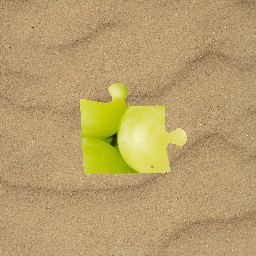

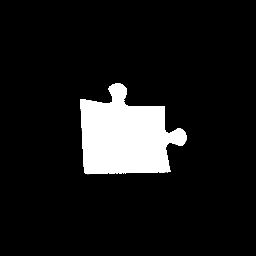

In [ ]:
img=dataset_train.__getitem__(1)
pil_image = torchvision.transforms.ToPILImage()(img[0])
pil_image.show()
pil_image = torchvision.transforms.ToPILImage()(img[1])
pil_image.show()

### Define Model

In [ ]:
class conv_block(nn.Module):
  def __init__(self, in_c, out_c):
    super().__init__()
    self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(out_c)
    self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(out_c)
    self.relu = nn.ReLU()

  def forward(self, inputs):
    x = self.conv1(inputs)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)
    return x

class encoder_block(nn.Module):
  def __init__(self, in_c, out_c):
    super().__init__()
    self.conv = conv_block(in_c, out_c)
    self.pool = nn.MaxPool2d((2, 2))

  def forward(self, inputs):
    x = self.conv(inputs)
    p = self.pool(x)
    return x, p

class decoder_block(nn.Module):
  def __init__(self, in_c, out_c):
    super().__init__()
    self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
    self.conv = conv_block(out_c+out_c, out_c)
  
  def forward(self, inputs, skip):
    x = self.up(inputs)
    x = torch.cat([x, skip], axis=1)
    x = self.conv(x)
    return x    

In [ ]:
class U_Net(nn.Module):
  def __init__(self):
    super().__init__()
    """ Encoder """
    self.e1 = encoder_block(3, 64)
    self.e2 = encoder_block(64, 128)
    self.e3 = encoder_block(128, 256)
    self.e4 = encoder_block(256, 512)
    
    """ Bottleneck """
    self.b = conv_block(512, 1024)
    
    """ Decoder """
    self.d1 = decoder_block(1024, 512)
    self.d2 = decoder_block(512, 256)
    self.d3 = decoder_block(256, 128)
    self.d4 = decoder_block(128, 64)
    
    """ Classifier """
    self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)
  
  def forward(self, inputs):
    """ Encoder """
    s1, p1 = self.e1(inputs)
    s2, p2 = self.e2(p1)
    s3, p3 = self.e3(p2)
    s4, p4 = self.e4(p3)
    
    """ Bottleneck """
    b = self.b(p4)
    
    """ Decoder """
    d1 = self.d1(b, s4)
    d2 = self.d2(d1, s3)
    d3 = self.d3(d2, s2)
    d4 = self.d4(d3, s1)
    
    """ Classifier """
    outputs = self.outputs(d4)
    return outputs

### Train Model

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = -1
    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            for _, (inputs, labels) in enumerate(tqdm(dataloaders[phase])):
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    
                    # labels = labels.reshape((labels.shape[0], 1))
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            if phase == 'train':
              train_loss_history.append(float(epoch_loss))
            else:
              val_loss_history.append(float(epoch_loss))
            print(f'{phase} Loss: {epoch_loss:.4f} ')
            wandb.log({f'{phase} Epoch Loss': epoch_loss}, step=epoch) 

            # deep copy the model
            if phase == 'val' and (epoch_loss < best_loss or best_loss == -1):
                print(f'Best loss was changed from {best_loss} to', end=' ')
                best_loss = epoch_loss
                print(f'{best_loss}')
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model, f"/content/gdrive/MyDrive/models/u-net.pt")

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_loss:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_acc_history, train_loss_history, val_acc_history, val_loss_history 

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = U_Net().to(device)
# print(model)

config_defaults = {
  'learning_rate': 0.003,
  'epochs': 30,
}

wandb.init(
   config=config_defaults,
   entity="disertatie",
   project="segmentation", 
   name=f"unet-0-003-shuffle-64batch"
)

criterion = nn.L1Loss()
optimizer_ft = optim.Adam(model.parameters(), lr=wandb.config.learning_rate)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model, train_acc, train_loss, val_acc, val_loss = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, wandb.config.epochs)

In [ ]:
torch.save(model, f"/content/gdrive/MyDrive/models/u-net.pt")

### Evaluation

In [ ]:
model_path = "/content/gdrive/MyDrive/models/u-net.pt"
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = torch.load(model_path, device)

In [ ]:
preds=[]
test_masks=[]
inp = []
with torch.no_grad():
  for inputs, masks in dataloaders['test']:
    inputs = inputs.to(device)
    masks = masks.to(device)
    inp += inputs
    test_masks += masks
    with torch.set_grad_enabled(False):
      outputs = model(inputs)
      for sublist in range(len(outputs)):
        for subsublist in range(len(outputs[sublist])):
          for sss in range(len(outputs[sublist][subsublist])):
            for item in range(len(outputs[sublist][subsublist][sss])):
              if float(outputs[sublist][subsublist][sss][item]) > 0.4:
                outputs[sublist][subsublist][sss][item] = 1
              else:
                outputs[sublist][subsublist][sss][item] = 0
      preds += outputs

In [ ]:
id = 100
test_img = preds[id]
# There's an extra dimension (1) to the masks. We need to remove it
# test_img = test_img.squeeze(1)
test_mask = test_masks[id]
# check img with id=22

print(inp[id].shape)
print(test_mask.shape)
print(test_img.shape)
# print(preds[0])

In [ ]:
from PIL import Image

pil_image = torchvision.transforms.ToPILImage()(test_img)
pil_image.show()
pil_image = torchvision.transforms.ToPILImage()(inp[id])
pil_image.show()
pil_image = torchvision.transforms.ToPILImage()(test_mask)
pil_image.show()

In [ ]:
preds2 = [float(item) for sublist in preds for subsublist in sublist for sss in subsublist for item in sss]
test_masks2 = [float(item) for sublist in test_masks for subsublist in sublist for sss in subsublist for item in sss]

In [ ]:
from sklearn.metrics import mean_absolute_error
print('Mean Absolute Error: ', mean_absolute_error(test_masks2, preds2))

In [ ]:
class_percent = {'0': 0, '1': 0}
total_per_class = {'0': 0, '1': 0}
for index in range(len(preds2)):
  if test_masks2[index] == 1.0:
    total_per_class['1'] += 1
    if preds2[index] >= 0.98 and preds2[index] <= 1.02:
      class_percent['1'] += 1
  else:
    total_per_class['0'] += 1
    if preds2[index] >= -0.02 and preds2[index] <= 0.02:
      class_percent['0'] += 1

print(total_per_class)
print(class_percent) 

In [ ]:
class_percent['0'] = class_percent['0']/total_per_class['0']*100
class_percent['1'] = class_percent['1']/total_per_class['1']*100
print(class_percent)

In [ ]:
def dice(inputs, targets, smooth=1e-7):
  # inputs = inputs.view(-1)
  # targets = targets.view(-1)
  intersection = (inputs * targets).sum()
  dice = (2.0 * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
  # loss = 1 - dice
  return dice

In [ ]:
# preds2 = [int(item) for item in preds2]
# test_masks2 = [int(item) for item in test_masks2]
preds2 = torch.tensor(preds2)
test_masks2 = torch.tensor(test_masks2)
print(dice(test_masks2, preds2))

### Test on new img

In [ ]:
model_path = "/content/gdrive/MyDrive/models/u-net-lr-0-003.pt"
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = torch.load(model_path, device)

In [ ]:
preds=[]
img = ''
with torch.no_grad():
  for id in range(1):
    img = Image.open("/content/vincent_3.JPG").convert('RGB') 

    img = transforms.Compose([
            transforms.ToTensor()
        ])(img)
    img_tensor = torch.Tensor.reshape(img.to(device), (1,3,256,256))

    with torch.set_grad_enabled(False):
      outputs = model(img_tensor)
      for sublist in range(len(outputs)):
        for subsublist in range(len(outputs[sublist])):
          for sss in range(len(outputs[sublist][subsublist])):
            for item in range(len(outputs[sublist][subsublist][sss])):
              if float(outputs[sublist][subsublist][sss][item]) > 0.99:
                outputs[sublist][subsublist][sss][item] = 1
              else:
                outputs[sublist][subsublist][sss][item] = 0
      preds += outputs

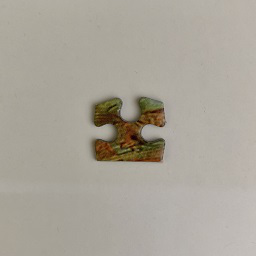

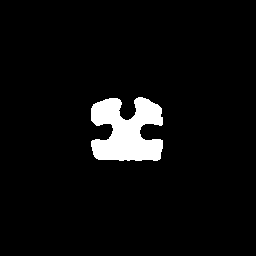

In [ ]:
from PIL import Image

pil_image = torchvision.transforms.ToPILImage()(img_tensor[0])
pil_image.show()
pil_image = torchvision.transforms.ToPILImage()(preds[0])
pil_image.show()
# pil_image = torchvision.transforms.ToPILImage()(test_mask)
# pil_image.show()